# Evaluating Fairness in Machine Learning: Comparative Analysis and Benchmarking of Fairlearn and AIF360 | German Credit Dataset

In [182]:
%load_ext autoreload
%autoreload 2

import os
import random

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import sklearn
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier

from src.constants import RANDOM_STATE, DEFAULT_MODEL_CONFIG, METRICFRAME_METRICS
from src.evaluation import plot_roc, print_confusion_matrix, calculate_fairlearn_metrics, calculate_aif360_metrics

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [134]:
sklearn.set_config(transform_output="pandas")

## Ensure reproducibility

Set random seeds for reproducibility.

In [135]:
np.random.seed(RANDOM_STATE)
os.environ["PYTHONHASHSEED"] = str(RANDOM_STATE)
random.seed(RANDOM_STATE)

## Load data

In [136]:
TARGET = "Creditability"
PROTECTED_ATTRIBUTE = "Sex & Marital Status"

In [137]:
data_raw = pd.read_csv("../data/german_credit_data.csv")
data = data_raw.copy()

In [138]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 21 columns):
 #   Column                             Non-Null Count  Dtype
---  ------                             --------------  -----
 0   Creditability                      1000 non-null   int64
 1   Account Balance                    1000 non-null   int64
 2   Duration of Credit (month)         1000 non-null   int64
 3   Payment Status of Previous Credit  1000 non-null   int64
 4   Purpose                            1000 non-null   int64
 5   Credit Amount                      1000 non-null   int64
 6   Value Savings/Stocks               1000 non-null   int64
 7   Length of current employment       1000 non-null   int64
 8   Instalment per cent                1000 non-null   int64
 9   Sex & Marital Status               1000 non-null   int64
 10  Guarantors                         1000 non-null   int64
 11  Duration in Current address        1000 non-null   int64
 12  Most valuable availab

In [139]:
data.isna().sum()

Creditability                        0
Account Balance                      0
Duration of Credit (month)           0
Payment Status of Previous Credit    0
Purpose                              0
Credit Amount                        0
Value Savings/Stocks                 0
Length of current employment         0
Instalment per cent                  0
Sex & Marital Status                 0
Guarantors                           0
Duration in Current address          0
Most valuable available asset        0
Age (years)                          0
Concurrent Credits                   0
Type of apartment                    0
No of Credits at this Bank           0
Occupation                           0
No of dependents                     0
Telephone                            0
Foreign Worker                       0
dtype: int64

In [140]:
data[TARGET].value_counts()

Creditability
1    700
0    300
Name: count, dtype: int64

In [141]:
data[PROTECTED_ATTRIBUTE].value_counts()

Sex & Marital Status
3    548
2    310
4     92
1     50
Name: count, dtype: int64

In [142]:
y = data.loc[:, TARGET]
z = data.loc[:, PROTECTED_ATTRIBUTE]
X = data.drop(columns=TARGET)

In [143]:
X_train, X_test, y_train, y_test, z_train, z_test = train_test_split(X, y, z, test_size=0.2, random_state=RANDOM_STATE, stratify=y)

In [144]:
MODEL_CONFIG = dict(DEFAULT_MODEL_CONFIG, cat_features=X.select_dtypes("object").columns.to_list())

In [145]:
default_model = CatBoostClassifier(**MODEL_CONFIG)
model = default_model.copy()

In [146]:
model.fit(X_train, y_train)

0:	learn: 0.6899831	total: 2.11ms	remaining: 6.33s
250:	learn: 0.4698964	total: 106ms	remaining: 1.16s
500:	learn: 0.4234232	total: 209ms	remaining: 1.04s
750:	learn: 0.3885434	total: 313ms	remaining: 937ms
1000:	learn: 0.3550001	total: 416ms	remaining: 831ms
1250:	learn: 0.3265120	total: 517ms	remaining: 722ms
1500:	learn: 0.3027580	total: 620ms	remaining: 620ms
1750:	learn: 0.2828691	total: 729ms	remaining: 520ms
2000:	learn: 0.2648067	total: 834ms	remaining: 416ms
2250:	learn: 0.2487316	total: 937ms	remaining: 312ms
2500:	learn: 0.2338165	total: 1.04s	remaining: 208ms
2750:	learn: 0.2203859	total: 1.15s	remaining: 104ms
2999:	learn: 0.2079273	total: 1.25s	remaining: 0us


In [147]:
y_pred = pd.Series(model.predict(X_test), name="y_pred", index=y_test.index)

In [148]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.59      0.53      0.56        60
           1       0.81      0.84      0.83       140

    accuracy                           0.75       200
   macro avg       0.70      0.69      0.69       200
weighted avg       0.74      0.75      0.75       200


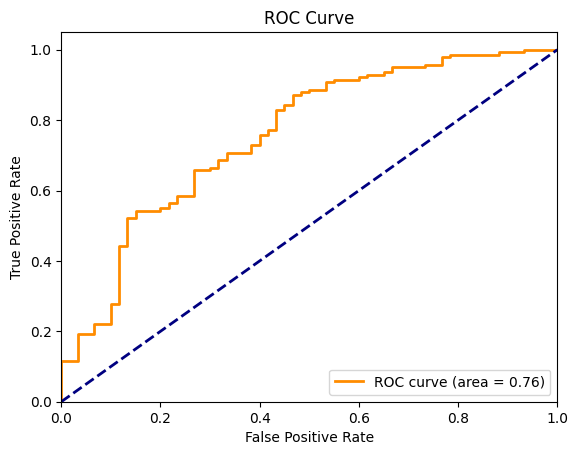

In [149]:
fig, ax = plt.subplots()
plot_roc(model, X_test, y_test, ax)

In [150]:
print_confusion_matrix(model, X_test, y_test)

Confusion Matrix:
[[ 32  28]
 [ 22 118]]


## Fairness assessment

### Fairlearn

#### Detection

In [151]:
from fairlearn.metrics import MetricFrame

In [187]:
mf = MetricFrame(
    metrics=METRICFRAME_METRICS,
    y_true=y_test,
    y_pred=y_pred,
    sensitive_features=z_test,
    random_state=RANDOM_STATE,
)

In [188]:
mf.overall

tpr        0.842857
fpr        0.466667
sel        0.730000
count    200.000000
dtype: float64

In [189]:
mf.by_group

,tpr,fpr,sel,count
Sex & Marital Status,,,,
1,0.500000,0.500000,0.500000,6.0
2,0.844444,0.333333,0.652778,72.0
3,0.875000,0.560000,0.800000,105.0
4,0.727273,0.666667,0.705882,17.0


In [183]:
calculate_fairlearn_metrics(y_test, y_pred, z_test)

,metric,type,method,value
8,demographic_parity,difference,between_groups,0.300000
10,demographic_parity,difference,to_overall,0.230000
9,demographic_parity,ratio,between_groups,0.625000
11,demographic_parity,ratio,to_overall,0.684932
0,equal_opportunity,difference,between_groups,0.375000
2,equal_opportunity,difference,to_overall,0.342857
1,equal_opportunity,ratio,between_groups,0.571429
3,equal_opportunity,ratio,to_overall,0.593220
4,equalized_odds,difference,between_groups,0.375000
6,equalized_odds,difference,to_overall,0.342857


#### Mitigation

In [156]:
from fairlearn.reductions import DemographicParity, ExponentiatedGradient

In [157]:
reduction = ExponentiatedGradient(estimator=default_model.copy(), constraints=DemographicParity(difference_bound=0.01), max_iter=10)
reduction.fit(X_train, y_train, sensitive_features=z_train)

/opt/homebrew/Caskroom/miniconda/base/envs/fairness-toolkits/lib/python3.10/site-packages/fairlearn/reductions/_moments/utility_parity.py:214: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  self.pos_basis[i]["+", e, g] = 1
/opt/homebrew/Caskr

0:	learn: 0.6899831	total: 518us	remaining: 1.55s
250:	learn: 0.4698964	total: 106ms	remaining: 1.16s
500:	learn: 0.4234232	total: 212ms	remaining: 1.05s
750:	learn: 0.3885434	total: 321ms	remaining: 961ms
1000:	learn: 0.3550001	total: 427ms	remaining: 853ms
1250:	learn: 0.3265120	total: 535ms	remaining: 749ms
1500:	learn: 0.3027580	total: 637ms	remaining: 636ms
1750:	learn: 0.2828691	total: 742ms	remaining: 529ms
2000:	learn: 0.2648067	total: 845ms	remaining: 422ms
2250:	learn: 0.2487316	total: 949ms	remaining: 316ms
2500:	learn: 0.2338165	total: 1.05s	remaining: 209ms
2750:	learn: 0.2203859	total: 1.16s	remaining: 105ms
2999:	learn: 0.2079273	total: 1.26s	remaining: 0us
0:	learn: 0.6899831	total: 566us	remaining: 1.7s
250:	learn: 0.4698964	total: 104ms	remaining: 1.14s
500:	learn: 0.4234232	total: 204ms	remaining: 1.02s
750:	learn: 0.3885434	total: 308ms	remaining: 921ms
1000:	learn: 0.3550001	total: 414ms	remaining: 826ms
1250:	learn: 0.3265120	total: 521ms	remaining: 729ms
1500:	le

In [158]:
y_pred_reduced = reduction.predict(X_test)

In [159]:
print(classification_report(y_test, y_pred_reduced))

              precision    recall  f1-score   support

           0       0.62      0.52      0.56        60
           1       0.81      0.86      0.83       140

    accuracy                           0.76       200
   macro avg       0.71      0.69      0.70       200
weighted avg       0.75      0.76      0.75       200


### AIF360

#### Detection

_"Since the main computation of confusion matrices is common for a large set of metrics, we utilize memoization and caching of computations for performance on large-scale datasets."_

In [190]:
priv_group = 3

In [191]:
calculate_aif360_metrics(y_test, y_pred, z_test, priv_group=priv_group)

,metric,type,method,value
0,demographic_parity,difference,other,-0.147368
1,demographic_parity,ratio,other,0.815789
2,equal_opportunity,difference,other,-0.075000


#### Mitigation

In [193]:
from aif360.sklearn.inprocessing import ExponentiatedGradientReduction as ExponentiatedGradientReductionAif

In [203]:
reduction_aif = ExponentiatedGradientReductionAif(prot_attr=PROTECTED_ATTRIBUTE, estimator=default_model.copy(), constraints=DemographicParity(difference_bound=0.01), max_iter=10, drop_prot_attr=False)

In [204]:
reduction_aif.fit(X_train, y_train)

0:	learn: 0.6899831	total: 567us	remaining: 1.7s
250:	learn: 0.4698964	total: 96.4ms	remaining: 1.06s


/opt/homebrew/Caskroom/miniconda/base/envs/fairness-toolkits/lib/python3.10/site-packages/fairlearn/reductions/_moments/utility_parity.py:214: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  self.pos_basis[i]["+", e, g] = 1
/opt/homebrew/Caskr

500:	learn: 0.4234232	total: 193ms	remaining: 962ms
750:	learn: 0.3885434	total: 291ms	remaining: 873ms
1000:	learn: 0.3550001	total: 385ms	remaining: 768ms
1250:	learn: 0.3265120	total: 483ms	remaining: 675ms
1500:	learn: 0.3027580	total: 581ms	remaining: 581ms
1750:	learn: 0.2828691	total: 683ms	remaining: 487ms
2000:	learn: 0.2648067	total: 782ms	remaining: 391ms
2250:	learn: 0.2487316	total: 880ms	remaining: 293ms
2500:	learn: 0.2338165	total: 983ms	remaining: 196ms
2750:	learn: 0.2203859	total: 1.08s	remaining: 98.1ms
2999:	learn: 0.2079273	total: 1.19s	remaining: 0us
0:	learn: 0.6899831	total: 446us	remaining: 1.34s
250:	learn: 0.4698964	total: 99.9ms	remaining: 1.09s
500:	learn: 0.4234232	total: 198ms	remaining: 986ms
750:	learn: 0.3885434	total: 298ms	remaining: 894ms
1000:	learn: 0.3550001	total: 399ms	remaining: 796ms
1250:	learn: 0.3265120	total: 501ms	remaining: 700ms
1500:	learn: 0.3027580	total: 604ms	remaining: 603ms
1750:	learn: 0.2828691	total: 708ms	remaining: 505ms
2

ExponentiatedGradientReduction(constraints=<fairlearn.reductions._moments.utility_parity.DemographicParity object at 0x29fbadc30>,
                               drop_prot_attr=False,
                               estimator=<catboost.core.CatBoostClassifier object at 0x29fc21480>,
                               max_iter=10, prot_attr='Sex & Marital Status')

In [205]:
y_pred_reduced_aif = reduction_aif.predict(X_test)

In [206]:
calculate_aif360_metrics(y_test, y_pred_reduced_aif, z_test, priv_group=priv_group)

,metric,type,method,value
0,demographic_parity,difference,other,-0.044110
1,demographic_parity,ratio,other,0.943517
2,equal_opportunity,difference,other,-0.012500


In [198]:
print(classification_report(y_test, y_pred_reduced_aif))


              precision    recall  f1-score   support

           0       0.61      0.50      0.55        60
           1       0.80      0.86      0.83       140

    accuracy                           0.76       200
   macro avg       0.71      0.68      0.69       200
weighted avg       0.74      0.76      0.75       200
